# Sentinel-2 image classification with Convolutional Neural Networks
## Adapted from Mort Canty

## Context
Image recognition with deep learning techniques such as the convolutional neural network (CNN) relies heavily on the availablity of vast amounts of labeled training data as well as a lot of computing resources. For typical remote sensing image classification these are usually not available.  We'll explore an alternative approach which makes use of pre-trained networks, freely available Sentinel-2 imagery, the EuroSAT Sentinel-2 training database and TensorFlow.

### References
[Géron (2019) Hands-On Machine Learning ...](https://b-ok.cc/book/5341845/f49201)

[Helber et al. (2017) EuroSAT: A novel dataset and deep learning benchmark ...](https://www.researchgate.net/publication/319463676_EuroSAT_A_Novel_Dataset_and_Deep_Learning_Benchmark_for_Land_Use_and_Land_Cover_Classification)

[Leitloff (2018) github.com/jensleitloff/CNN-Sentinel](https://github.com/jensleitloff/CNN-Sentinel)

[Mort Canti https://github.com/mortcanty](https://github.com/mortcanty)

[Sumbul et al. (2020) BigEarthNet: Dataset with a new class-nomenclature for remote sensing image understanding](https://arxiv.org/abs/2001.06372)

### Software

[Python scripts](https://drive.google.com/drive/folders/1D2RAEu14Zcl9NzqWkSg4J7MilHGHi0BH?usp=sharing)

## Preliminaries

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import IPython.display as disp

%matplotlib inline

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/My Drive/Didattica/Corsi/AI/Lectures/Lecture16+17/TerrainClassification/

%ls

Mounted at /content/drive/
/content/drive/My Drive/Didattica/AI/Lectures/Lecture16+17/TerrainClassification
eurosat_model.png  log1/  s2cnnclass.ipynb  Visualize_and_classify.ipynb
GEE/               log2/  scripts/


In [ ]:
import ee
ee.Authenticate()

ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=A8B_o-Ab6YpYhgzXmVWA67RvmnqAhzGKbriSIvYqETA&tc=zNp23oh_FJoM5ALf7Vt7QgU0XHrIaNCJG6Nly2Uhk1A&cc=Sbv2K9I8diuraDflnZfSuZ88dI3AJwKnGju-Xix7XkU

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk6beVb9yrwUbt9ThsGqx1tP8Cn3rq3A9BCHTVgLFpjXOmrbtMEpOqw

Successfully saved authorization token.


In [ ]:
!ls scripts

AAFC.txt   em.py       iMad_tf.py  s2cloudless.py    unetclassify.py
dispms.py  iMadmap.py  plr.py	   S2cnnclassify.py


## Transfer Learning with the EuroSAT/rgb dataset
Transfer Learning is a deep learning technique whereby a model developed for a task is reused as the initial point for a model in another domain. Rather than training the model from scratch, the pre-trained model is modified, partially retrained and re-used.

### EUROSAT dataset (27000 Sentinel-2 RGB 64x64 images with labels)

This dataset is part of the TFDS project. We use it to download the EuroSAT database and split  it into test, train and validate subsets.

In [ ]:
(test_set, valid_set, train_set), info = tfds.load('eurosat/rgb', split = ['train[:10%]', 'train[10%:25]', 'train[25%:]' ], as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteQ56CNP/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
info.description

'EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral\nbands and consisting of 10 classes with 27000 labeled and\ngeo-referenced samples.\n\nTwo datasets are offered:\n- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.\n- all: Contains all 13 bands in the original value range (float32).\n\nURL: https://github.com/phelber/eurosat'

In [ ]:
info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'image': Image(shape=(64, 64, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [ ]:
info.features['label'].names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

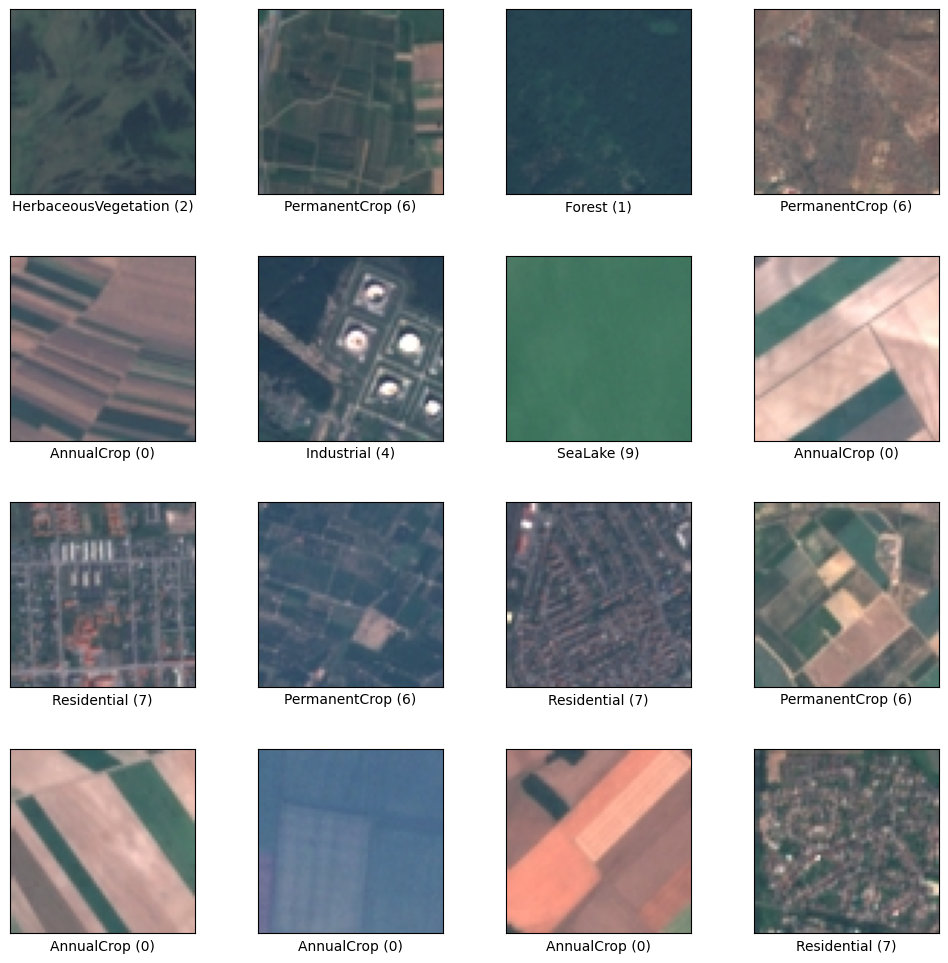

In [ ]:
fig=tfds.show_examples(train_set, info, rows=4, cols=4)

### Preprocess for Xception cnn
We will use the [Xception CNN](https://keras.io/api/applications/xception/) which has been pre-trained with the [IMAGENET](http://image-net.org/) database. The CNN requires image patches with dimension 224x224 and has its own preprocessor:

In [ ]:
def preprocess(image,label):
    resized_image = tf.image.resize(image, [224,224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
# Randomly shuffle the elements of the training dataset.
train_set = train_set.shuffle(1000)
# map the preprocessing function over the three datasets
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

test_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

For a GPU runtime, the _prefetch_ method makes the CPU prepare the next batch while the GPU is processing the current one.

### Setup the pre-trained xception model using weights obtained for the IMAGENET dataset

So far we have built our networks with the Keras sequential API. Here we use the more flexible _functional API_.

In [ ]:
# download xception (base) model without top layers
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))
# add a pooling layer with input from the base model (averages over all output feature maps of the base model)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# add an output softmax layer with 10 neurons and softmax activation
output = keras.layers.Dense(10, activation='softmax')(avg)
# define the model
model = keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
#keras.utils.plot_model(model, "eurosat_model.png", dpi=48, show_shapes=True)

Freeze the layers in the base model

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Define optimization method and compile the model

In [ ]:
# scaled gradient descent optimizer
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
# cross entropy loss (for no one-hot labels encoding)
loss = "sparse_categorical_crossentropy"
# only display accuracy = overall correct / total examples
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Train the model, top layer weights only (use GPU runtime!)

In [ ]:
%time
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
logdir1 = '/content/drive/My Drive/Didattica/AI/Lectures/Lecture16+17/TerrainClassification/log1/run-'+str(now)
# default: save checkpoint after each epoch
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/Didattica/AI/Lectures/Lecture16+17/TerrainClassification/gee/first_training.model.weights.best.hdf5', verbose = 1, save_best_only=True)
tensorboardlog = TensorBoard(logdir1)

history = model.fit(train_set, epochs=10, validation_data=valid_set, callbacks=[checkpointer,tensorboardlog])

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 30 µs
Epoch 1/10
633/633 [==============================] - ETA: 0s - loss: 0.3782 - accuracy: 0.8883
Epoch 1: val_loss improved from inf to 0.25268, saving model to /content/drive/My Drive/Didattica/AI/Lectures/Lecture16+17/TerrainClassification/gee/first_training.model.weights.best.hdf5
633/633 [==============================] - 117s 166ms/step - loss: 0.3782 - accuracy: 0.8883 - val_loss: 0.2527 - val_accuracy: 0.9267
Epoch 2/10
633/633 [==============================] - ETA: 0s - loss: 0.1889 - accuracy: 0.9376
Epoch 2: val_loss improved from 0.25268 to 0.21744, saving model to /content/drive/My Drive/Didattica/AI/Lectures/Lecture16+17/TerrainClassification/gee/first_training.model.weights.best.hdf5
633/633 [==============================] - 107s 169ms/step - loss: 0.1889 - accuracy: 0.9376 - val_loss: 0.2174 - val_accuracy: 0.9331
Epoch 3/10
633/633 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9458


In [ ]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(10)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

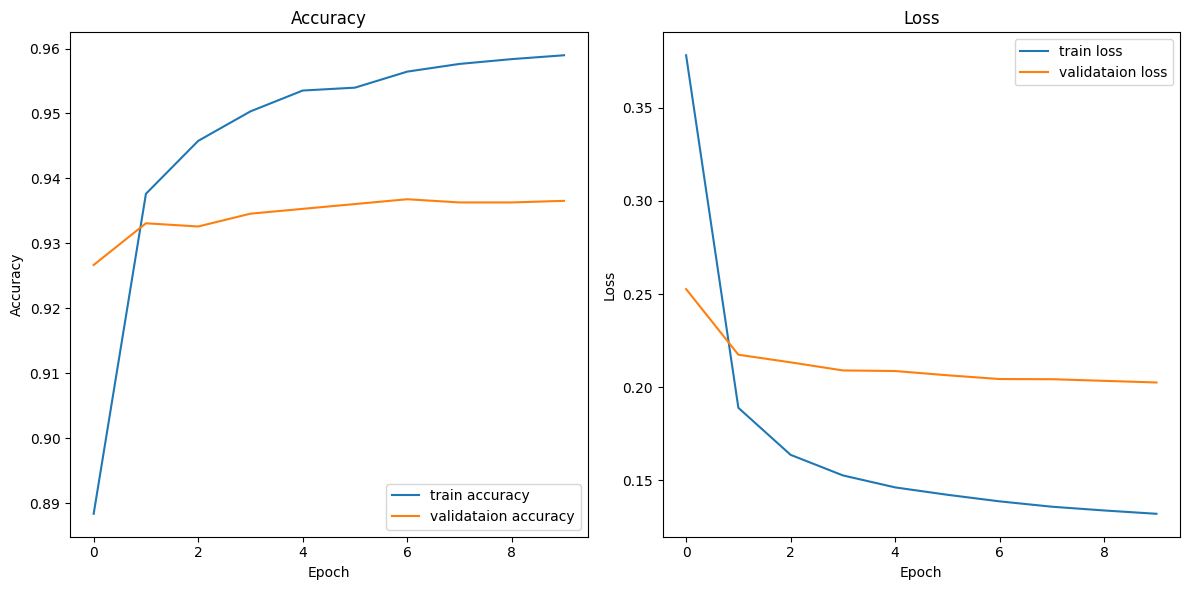

In [ ]:
# Display learning curves
display_learning_curves(history)

Fine tune the rest of the weights

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
logdir2 = '/content/drive/My Drive/Didattica/Corsi/AI/Lectures/Lecture16+17/TerrainClassification/log2/run-'+str(now)
# default: save checkpoint after each epoch
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/Didattica/Corsi/AI/Lectures/Lecture16+17/TerrainClassification/gee/second_training.model.weights.best.hdf5', verbose = 1, save_best_only=True)
tensorboardlog = TensorBoard(logdir2)

optimizer = keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_set, epochs=5, validation_data=valid_set, callbacks=[checkpointer,tensorboardlog])

Epoch 1/5
633/633 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.9422
Epoch 1: val_loss improved from inf to 0.06824, saving model to /content/drive/My Drive/Didattica/AI/Lectures/Lecture16+17/TerrainClassification/gee/second_training.model.weights.best.hdf5
633/633 [==============================] - 357s 550ms/step - loss: 0.1822 - accuracy: 0.9422 - val_loss: 0.0682 - val_accuracy: 0.9756
Epoch 2/5
633/633 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9851
Epoch 2: val_loss improved from 0.06824 to 0.06037, saving model to /content/drive/My Drive/Didattica/AI/Lectures/Lecture16+17/TerrainClassification/gee/second_training.model.weights.best.hdf5
633/633 [==============================] - 340s 536ms/step - loss: 0.0466 - accuracy: 0.9851 - val_loss: 0.0604 - val_accuracy: 0.9785
Epoch 3/5
633/633 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9940
Epoch 3: val_loss improved from 0.06037 to 0.05657, saving mode

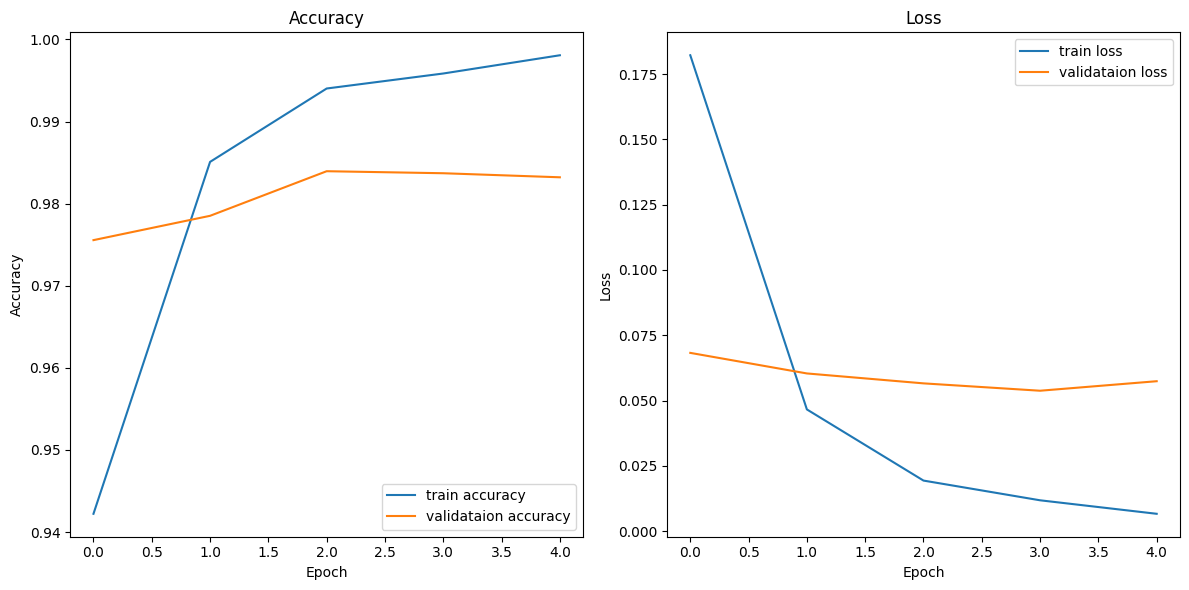

In [ ]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(5)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

# Display learning curves
display_learning_curves(history)

Test (on first 32 test examples)

In [ ]:
print( np.argmax(model.predict(test_set.take(1)),1) )
for image, label in test_set.take(1):
  print(np.array(label))

1/1 [==============================] - 1s 1s/step
[1 7 2 7 1 0 8 0 1 7 4 8 5 4 8 6 1 4 1 0 6 9 1 2 4 1 0 0 1 1 3 9]
[1 7 2 7 1 0 8 0 1 7 4 8 5 4 9 6 1 4 1 0 4 9 1 2 4 1 0 0 1 1 3 8]


In [ ]:
model.evaluate(test_set)

85/85 [==============================] - 12s 139ms/step - loss: 0.0638 - accuracy: 0.9807


[0.06383173167705536, 0.9807407259941101]

 Save the model

In [ ]:
model.save('/content/drive/My Drive/Didattica/Corsi/AI/Lectures/Lecture16+17/TerrainClassification/gee/eurosat_model.h5')